In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

# from xgboost import XGBClassifier





from sklearn.metrics import make_scorer, fbeta_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
scorer = make_scorer(fbeta_score, beta=1.5)

# Some warnings tend to pop up during grid search
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline


# target is predicting if there's a match or not 


In [3]:
dating = pd.read_csv('/Users/andreewerner/Desktop/speed_dating_data.csv',encoding="ISO-8859-1")


In [4]:
dating.shape
dating.dtypes.value_counts()

float64    174
int64       13
object       8
dtype: int64

In [5]:
# 277 men and 274 women, men are 1, women 0
dating.groupby('iid').mean().gender.value_counts()


1.0    277
0.0    274
Name: gender, dtype: int64

In [6]:
dating['match'].value_counts(normalize=True)

0    0.835283
1    0.164717
Name: match, dtype: float64

0    0.835283
1    0.164717
Name: match, dtype: float64


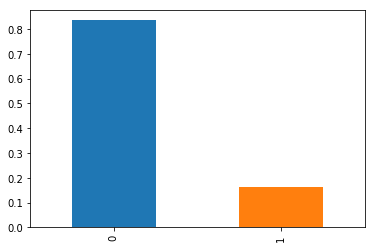

In [7]:
target_pcts = dating['match'].value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar')


In [8]:
points = (dating['wave'] != 6 ) &\
    (dating['wave'] != 7 ) &\
    (dating['wave'] != 8 ) &\
    (dating['wave'] != 9 )
#     (dating['wave'] != 10 )&\
#     (dating['wave'] != 11 )


dating = dating[points]


In [9]:
# define some new columns
# desirability: how desirable are you to parnter , using dec_o which is decision of your partner night of, so how desirable are you to partner
desirability = dating.groupby('iid').mean()['dec_o'].to_dict()
dating['desirability']=dating['iid'].map(desirability)


# choosy: how choosy about partner are you, using dec as your decision night of, so how choosy are you
choosy = dating.groupby('iid').mean()['dec'].to_dict()
dating['choosy'] = dating['iid'].map(choosy)



In [10]:
# remove responses/features that are too similar to target (i.e. questions like "how attracted are you to this person?")

match_correlations = dating.select_dtypes(include=[np.number]).corrwith(dating['match']).sort_values(ascending=False)

match_correlations = match_correlations[match_correlations > .25].index

dating = dating.dropna(subset=['id', 'pid'], axis=0)

for i in match_correlations[1:]:
    del dating[i]

# delete columns that are too predictive of my target
del dating['int_corr']
del dating['them_cal']
del dating['you_call']

del dating['field'] # redundant because field_cd gives field of study already 


match_correlations


Index(['match', 'dec_o', 'dec', 'like_o', 'like', 'fun_o', 'fun', 'shar_o',
       'shar', 'attr_o', 'attr', 'prob_o', 'prob'],
      dtype='object')

In [11]:
# change columns that are strings currently but should be numeric like zip, median SAT score for where they went undergrad, tuition, income
def change_to_number(col, df=dating, median=False):
    try:
        df[col] = df[col].str.replace(',', '')
    except:
        print('not a string')
    
    df[col] = df[col].astype(float)

    if median:
        df[col] = df[col].fillna(dating.fillna.median())
    
    else:
        df[col] = df[col].fillna(-100)
    
    return df

for i in 'zipcode mn_sat tuition income'.split():
    dating = change_to_number(i)

In [12]:
# change strings to lowercase 

for i in dating.columns:
    if dating[i].dtype == "O":
        dating[i] = dating[i].str.lower()
        print(i, end=', ')



undergra, from, career, 

In [13]:
from sklearn.dummy import DummyClassifier



benchmark = pd.get_dummies(dating)
benchmark.fillna(benchmark.median(), inplace=True)

Xbench = benchmark.drop('match', axis=1)
ybench = benchmark['match']

dummy = DummyClassifier(strategy='constant', constant=1)

crossvalscore = cross_val_score(dummy, Xbench, ybench, scoring=scorer, cv=5)

benchmark_score = crossvalscore.mean()

print('Naive Benchmark:', benchmark_score)

Naive Benchmark: 0.3913646168678066


In [14]:
dating.shape

(6805, 181)

## feature engineer

In [15]:
dating['from_new_england'] = 0
for i in 'massachu connect rhode vermont vt hampshire maine boston cambridge'.split():
    dating['from_new_england'] = np.where((dating['from'].str.contains(i)) | (dating['undergra'].str.contains(i)), 1, dating['from_new_england'])

dating['from_china'] = 0
for i in 'china beijing shanghai hong taiwan'.split():
    dating['from_china'] = np.where((dating['from'].str.contains(i)) | (dating['undergra'].str.contains(i)), 1, dating['from_china'])

dating['from_india'] = 0
for i in 'india delhi bangalore'.split():
    dating['from_india'] = np.where((dating['from'].str.contains(i)) | (dating['undergra'].str.contains(i)), 1, dating['from_india'])

dating['from_europe'] = 0
for i in 'europe germany italy france spain poland portugal netherlands holland sweden switz greece belgium paris rome'.split():
    dating['from_europe'] = np.where((dating['from'].str.contains(i)) | (dating['undergra'].str.contains(i)), 1, dating['from_europe'])

dating['from_uk'] = 0
for i in 'london england uk britain scotland ireland kingdom oxford'.split():
    dating['from_uk'] = np.where((dating['from'].str.contains(i)) | (dating['undergra'].str.contains(i)), 1, dating['from_uk'])


dating['from_ny'] = 0
for i in ['new york', 'ny']:
    dating['from_ny'] = np.where((dating['from'].str.contains(i)) | (dating['undergra'].str.contains(i)), 1, dating['from_ny'])


dating['from_nj'] = 0
for i in ['new jersey', 'nj']:
    dating['from_nj'] = np.where((dating['from'].str.contains(i)) | (dating['undergra'].str.contains(i)), 1, dating['from_nj'])


dating['from_california'] = 0
for i in 'cali diego francisco jose davis sacramento oakland clara angeles ucla stanford berkeley alto torrance'.split():
    dating['from_california'] = np.where((dating['from'].str.contains(i)) | (dating['undergra'].str.contains(i)), 1, dating['from_california'])

dating['from_texas'] = 0
for i in 'texas tx dallas austin houston dfw antonio'.split():
    dating['from_texas'] = np.where((dating['from'].str.contains(i)) | (dating['undergra'].str.contains(i)), 1, dating['from_texas'])
 


In [16]:
dating['education'] = 0
for i in 'professor teach academ educ'.split():
    dating['education'] = np.where(dating['career'].str.contains(i), 1, dating['education'])

dating['law'] = 0
for i in 'law attorney legal defender counsel'.split():
    dating['law'] = np.where(dating['career'].str.contains(i), 1, dating['law'])

dating['medicine'] = 0
for i in 'doctor dr physician md medical m.d. cardio dentist surg'.split():
    dating['medicine'] = np.where(dating['career'].str.contains(i), 1, dating['medicine'])

dating['business'] = 0
for i in 'business mba m.b.a. consult manage ceo c.e.o. entre finance venture market strategy invest bank equity'.split():
    dating['business'] = np.where(dating['career'].str.contains(i), 1, dating['business'])
    
dating['science'] = 0
for i in 'sci research biolo chemi'.split():
    dating['science'] = np.where(dating['career'].str.contains(i), 1, dating['science'])

dating['politics'] = 0
for i in 'gov diplo poli'.split():
    dating['politics'] = np.where(dating['career'].str.contains(i), 1, dating['politics'])
dating.shape


(6805, 196)

In [17]:
dating['Columbia'] = 0
for i in 'columbia'.split():
    dating['Columbia'] = np.where(dating['undergra'].str.contains(i),1, dating['Columbia'])

# Ivy league and other prestigious schools
dating['Schools'] = 0
for i in 'dartmouth cornell princeton penn yale brown harvard stanford mit berkeley oxford'.split():
    dating['Schools'] = np.where(dating['undergra'].str.contains(i), 1, dating['Schools'])

dating.shape

(6805, 198)

In [18]:
# Dummify
dating = pd.get_dummies(dating, prefix='dummy')

#fix duplicate column names
cols = pd.Series(dating.columns)

for duplicate in dating.columns.get_duplicates():
    cols[dating.columns.get_loc(duplicate)] = [duplicate+'.'+str(d_idx) if d_idx!=0 else duplicate for d_idx in range(dating.columns.get_loc(duplicate).sum())]

dating.columns = cols

dating.shape

(6805, 914)

In [19]:
# dating.dtypes
pd.options.display.max_columns = 195


dating.isnull().sum().sort_values(ascending=False)[:10]



num_in_3    6217
numdat_3    5745
expnum      5015
amb7_2      4851
sinc7_2     4851
shar7_2     4832
intel7_2    4822
attr7_2     4822
fun7_2      4822
shar4_3     4790
dtype: int64

In [20]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
# from sklearn.neighbors import KNeighborsClassifier

pd.options.display.max_columns = 195


In [21]:
dating.columns[dating.isna().any()].tolist()
dating.shape
dating.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,match,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,sinc_o,intel_o,amb_o,met_o,age,field_cd,mn_sat,tuition,race,imprace,imprelig,zipcode,income,goal,date,go_out,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,sinc,intel,amb,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,...,dummy_playing music,dummy_political development in africa,dummy_politics,dummy_porn star,dummy_president,dummy_private equity,dummy_private equity - leveraged buy-outs,dummy_private equity investing,dummy_private practice dietician,dummy_pro beach volleyball,dummy_producer at a non-profit regional theatre,dummy_professional career,dummy_professor,dummy_professor in college,dummy_professor of education,dummy_professor of media studies,dummy_professor or journalist,dummy_professor or lawyer,"dummy_professor, or engineer","dummy_professor, poet/critic",dummy_professor...?,dummy_professor; human rights director,dummy_program development / policy work,dummy_psychologist,dummy_public finance,dummy_public school principal,dummy_real estate,dummy_real estate consulting,"dummy_reorganizing society. no, i am not being flip.",dummy_research,dummy_research - teaching,dummy_research engineer,dummy_research in industry or academia,dummy_research position in pharmaceutical industry,dummy_research scientist,dummy_research/academia,dummy_research/financial industry,dummy_research/teaching,dummy_researcher,dummy_researcher in sociology,dummy_researcher/academia,dummy_school counseling,dummy_school leadership/politics,dummy_school psychologist,dummy_science,dummy_scientific research for now but who knows,dummy_scientist,dummy_scientist/educator,dummy_screenwriter,dummy_secondary education teacher,dummy_security policy - homeland defense,dummy_self-made millionare,dummy_sex therapist,dummy_social services/ policy,dummy_social work,dummy_social work administration,dummy_social work policy,dummy_social work with children,dummy_social worker,dummy_social worker.... clinician,"dummy_software engr, network engr",dummy_speech language pathologist,dummy_speech pathologist,dummy_still wondering,dummy_tax lawyer,dummy_teacher,dummy_teacher and performer,dummy_teacher/professor,dummy_teaching,dummy_teaching and then...,dummy_teaching/education,dummy_tech professional,dummy_to create early childhood intervention programs,dummy_to get ph.d and be a professor,dummy_to go into finance,dummy_trade specialist,dummy_trader,dummy_trading,dummy_undecided,dummy_university president,dummy_university professor,dummy_unknown,dummy_unsure,dummy_urban planner,dummy_venture capital/consulting/government,dummy_wall street economist,dummy_what a question!,dummy_who knows,dummy_work at the un,dummy_work in an investment bank,dummy_writer,dummy_writer/editor,dummy_writer/journalist,dummy_writer/producer,dummy_writer/teacher,dummy_writing,dummy_writing or editorial
0,1,1.0,0,1,1,1,10,7,NaN,4,1,11.0,0,0,27.0,2.0,35.0,20.0,20.0,20.0,0.0,5.0,8.0,8.0,8.0,2.0,21.0,1.0,-100.0,-100.0,4.0,2.0,4.0,60521.0,69487.0,2.0,7.0,1.0,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,9.0,7.0,6.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1.0,0,1,1,1,10,7,NaN,3,2,12.0,0,0,22.0,2.0,60.0,0.0,0.0,40.0,0.0,0.0,8.0,10.0,7.0,2.0,21.0,1.0,-100.0,-100.0,4.0,2.0,4.0,60521

In [22]:
dating.shape


(6805, 914)

In [23]:
# null_cols = dating.isnull().sum()
# null_cols = list(null_cols[null_cols != 0].index)

# for i in null_cols:
#     #print(i, 'has', data[i].isnull().sum(), 'missing values')
#     X = dating.fillna(dating.mean()).drop(['match', 'id'], axis=1)
#     y = X.pop(i)
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#     reg = KNeighborsRegressor()
#     reg.fit(X_train, y_train)      
#     pred = reg.predict(X_test)
#     r2 = r2_score(y_test, pred)
    
#     # If we can reasonably predict these values, do so
#     if r2 > .20:
#         #print('regressing', i, 'with an r2 of', round(r2, 3))
#         dating['predicted'] = reg.predict(dating.fillna(dating.median()).drop([i, 'match', 'id'], axis=1))
#         dating[i] = np.where(dating[i].isnull(), dating['predicted'], dating[i])
#         del dating['predicted']
    
#     # Otherwise, just take the median
#     else:
#         #print('averaging', i)
#         dating[i] = dating[i].fillna(dating[i].median())
#     #print

In [24]:
from numpy import *

null_cols = dating.isnull().sum()
null_cols = list(null_cols[null_cols != 0].index)

for col in null_cols:
    dating[col] = dating[col].fillna(dating[col].median()) 



In [25]:
dating.isnull().sum().sort_values(ascending=False)[:10]


dummy_writing or editorial     0
dummy_queens college           0
dummy_princeton university     0
dummy_princeton u.             0
dummy_princeton                0
dummy_penn state university    0
dummy_pace university          0
dummy_oxford university        0
dummy_oxford                   0
dummy_occidental college       0
dtype: int64

In [26]:
dating.shape


(6805, 914)

In [27]:
dating.isnull().sum().sort_values(ascending=False)[:50]


dummy_writing or editorial                      0
dummy_queens college                            0
dummy_princeton university                      0
dummy_princeton u.                              0
dummy_princeton                                 0
dummy_penn state university                     0
dummy_pace university                           0
dummy_oxford university                         0
dummy_oxford                                    0
dummy_occidental college                        0
dummy_oberlin college                           0
dummy_oberlin                                   0
dummy_nyu                                       0
dummy_nus                                       0
dummy_novosibirsk state university              0
dummy_notre dame                                0
dummy_northwestern university                   0
dummy_nirma institute of technology-india       0
dummy_new york university                       0
dummy_national university of singapore          0


In [28]:
# Look up the person's partner and add their data as new features. If the partner ID doesn't exist, return -1
def get_partner_info(pid, col):
 
    try:
        partner = dating[dating['iid'] == 'pid'].head(1)[col].iloc[0]
        if partner:
            return partner
        else:
            return -1
    except:
        return -1

# Income (where income data is available, take the log difference)
dating['partner_income'] = dating['pid'].apply(get_partner_info, col='income')
dating['income_difference'] = np.where((dating['partner_income'] == -1) |\
                                     (dating['income'] == -1),
                                     -1, np.log1p(np.abs(dating['income'] - dating['partner_income'])))

# Age
dating['age'].fillna(dating['age'].median(), inplace=True)
dating['age_o'].fillna(dating['age_o'].median(), inplace=True)
dating['age_difference'] = dating['age'] - dating['age_o']



In [29]:
dating.shape

(6805, 917)

In [30]:
# This is important: compare the each person's overall desirability to their partner's.

dating['partner_desirability'] = dating['pid'].apply(get_partner_info, col='desirability')

dating['des_diff'] = dating['desirability'] - dating['partner_desirability']

# Also for Choosiness

dating['partner_choosiness'] = dating['pid'].apply(get_partner_info, col='choosiness')

dating['choose_diff'] = dating['choosy'] - dating['partner_choosiness']


In [31]:
# Attractiveness
dating['partner_attractiveness'] = dating['pid'].apply(get_partner_info, col='attr3_1')
dating['attr_expectations'] = (10*dating['attr1_1']/dating['attr1_1'].max()) - dating['partner_attractiveness']

dating['partner_attractiveness_2'] = dating['pid'].apply(get_partner_info, col='attr5_1')
dating['attr_expectations_2'] = (10*dating['attr1_1']/dating['attr1_1'].max()) - dating['partner_attractiveness_2']

# Intelligence
dating['partner_intelligence'] = dating['pid'].apply(get_partner_info, col='intel3_1')
dating['intel_expectations'] = (10*dating['intel1_1']/dating['intel1_1'].max()) - dating['partner_intelligence']

dating['partner_intelligence_2'] = dating['pid'].apply(get_partner_info, col='intel5_1')
dating['intel_expectations_2'] = (10*dating['intel1_1']/dating['intel1_1'].max()) - dating['partner_intelligence_2']

# Fun
dating['partner_fun'] = dating['pid'].apply(get_partner_info, col='fun3_1')
dating['fun_expectations'] = (10*dating['fun1_1']/dating['fun1_1'].max()) - dating['partner_fun']

dating['partner_fun_2'] = dating['pid'].apply(get_partner_info, col='fun5_1')
dating['fun_expectations_2'] = (10*dating['fun1_1']/dating['fun1_1'].max()) - dating['partner_fun_2']

# Ambitious
dating['partner_ambition'] = dating['pid'].apply(get_partner_info, col='amb3_1')
dating['amb_expectations'] = (10*dating['amb1_1']/dating['amb1_1'].max()) - dating['partner_ambition']

dating['partner_ambition_2'] = dating['pid'].apply(get_partner_info, col='amb5_1')
dating['amb_expectations_2'] = (10*dating['amb1_1']/dating['amb1_1'].max()) - dating['partner_ambition_2']

# Sincerity
dating['partner_sincerity'] = dating['pid'].apply(get_partner_info, col='sinc3_1')
dating['sinc_expectations'] = (10*dating['sinc1_1']/dating['sinc1_1'].max()) - dating['partner_sincerity']

dating['partner_sincerity_2'] = dating['pid'].apply(get_partner_info, col='sinc5_1')
dating['sinc_expectations_2'] = (10*dating['sinc1_1']/dating['sinc1_1'].max()) - dating['partner_sincerity_2']



In [32]:
# Measuring expectations one more way

dating['attr_above_avg'] = np.where(dating['partner_attractiveness'] > dating['partner_attractiveness'].mean(),
                                  1, 0)
dating['attr_imp_above_avg']= np.where(dating['attr1_1'] > dating['attr1_1'].mean(),
                                     1, 0)
dating['attr_match'] = np.where(dating['attr_above_avg'] >= dating['attr_imp_above_avg'],
                             1, 0)

dating['sinc_above_avg'] = np.where(dating['partner_sincerity'] > dating['partner_sincerity'].mean(),
                                  1, 0)
dating['sinc_imp_above_avg']= np.where(dating['sinc1_1'] > dating['sinc1_1'].mean(),
                                     1, 0)
dating['sinc_match'] = np.where(dating['sinc_above_avg'] >= dating['sinc_imp_above_avg'],
                             1, 0)

dating['int_above_avg'] = np.where(dating['partner_intelligence'] > dating['partner_intelligence'].mean(),
                                  1, 0)
dating['int_imp_above_avg']= np.where(dating['intel1_1'] > dating['intel1_1'].mean(),
                                     1, 0)
dating['int_match'] = np.where(dating['int_above_avg'] >= dating['int_imp_above_avg'],
                             1, 0)

dating['fun_above_avg'] = np.where(dating['partner_fun'] > dating['partner_fun'].mean(),
                                  1, 0)
dating['fun_imp_above_avg']= np.where(dating['fun1_1'] > dating['fun1_1'].mean(),
                                     1, 0)
dating['fun_match'] = np.where(dating['fun_above_avg'] >= dating['fun_imp_above_avg'],
                             1, 0)



In [33]:
dating.shape

(6805, 953)

In [34]:
# Ambition (doing this one differently)

# Temporarily replace missing values with the median
dating['income_temp'] = np.where(dating['income'] == -100, dating['income'].median(), dating['income'])

dating['income_above_avg']= np.where(dating['income_temp'] > dating['income_temp'].median(), 1, 0)
dating['partner_income_above_avg'] = dating['pid'].apply(get_partner_info, col='income_above_avg')

dating['amb_imp_above_avg'] = np.where(dating['amb1_1'] > dating['amb1_1'].mean(), 1, 0)

dating['amb_match'] = np.where(dating['partner_income_above_avg'] >= dating['amb_imp_above_avg'],1, 0)
del dating['income_temp']



In [35]:
#for when the 2 people went to the same school, have similar career ambitions, or are from same place 
cols = dating.columns

for i in cols:
    if 'from_' in i:
        dating['partner_location'] = dating['pid'].apply(get_partner_info, col=i)
        dating['both_' + i] = np.where((dating[i] == 1) & (dating['partner_location'] == 1), 1, 0)
        del dating['partner_location']
        
for i in cols:
    if 'school_' in i:
        dating['partner_education'] = dating['pid'].apply(get_partner_info, col=i)
        dating['both_' + i] = np.where((dating[i] == 1) & (dating['partner_education'] == 1), 1, 0)
        del dating['partner_education']
        
for i in cols:
    if 'career_' in i:
        dating['partner_career'] = dating['pid'].apply(get_partner_info, col=i)
        dating['both_' + i] = np.where((dating[i] == 1) & (dating['partner_career'] == 1), 1, 0)
        del dating['partner_career']



In [36]:
# same thing for hobbies: when 2 people have hobbies in common

hobbies = ['go_out', 'sports', 'tvsports', 'exercise', 'dining', 'museums',
 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater',
 'movies', 'concerts', 'music', 'shopping', 'yoga']

for i in hobbies:
    dating['partner_' + i] = dating['pid'].apply(get_partner_info, col=i)
    dating[i + '_in_common'] = np.where((dating[i] > 7) & (dating['partner_' + i] > 7), 1, 0)
    del dating['partner_' + i]



In [37]:
counts =\
dating.groupby('iid').mean().sum(axis=0).sort_values()

deleted = []

for i in counts[counts < 2].index:
    if 'dummy_' in i:
        deleted.append(i)
        del dating[i]

# Fix anything that got counted twice
for i in dating.columns:
    if 'dummy_' in i:
        dating[i] = np.where(dating[i] >= 1, 1, 0)



KeyError: 'dummy_bowdoin college.1'

In [38]:
print('Deleted:', len(deleted))
print('Data shape:', dating.shape)

Deleted: 448
Data shape: (6805, 534)


In [39]:
cols = dating.drop(['match', 'pid'], axis=1).columns
for i in cols:
    try:
        dating['pid'].apply(get_partner_info, col=i)
    except:
        continue

In [40]:
dating['zipcode'] = dating['zipcode'].astype(str)
dating['zip_5'] = (dating['zipcode'].str[:5]).astype(float)
dating['zip_4'] = (dating['zipcode'].str[:4]).astype(float)
dating['zip_3'] = (dating['zipcode'].str[:3]).astype(float)
dating['zip_2'] = (dating['zipcode'].str[:2]).astype(float)
del dating['zipcode']

dating['partner_zip'] = dating['pid'].apply(get_partner_info, col='zipcode')
dating['partner_zip'] = dating['partner_zip'].astype(str)
dating['partner_zip_5'] = (dating['partner_zip'].str[:5]).astype(float)
dating['partner_zip_4'] = (dating['partner_zip'].str[:4]).astype(float)
dating['partner_zip_3'] = (dating['partner_zip'].str[:3]).astype(float)
dating['partner_zip_2'] = (dating['partner_zip'].str[:2]).astype(float)
del dating['partner_zip']


In [41]:
cols = dating.columns

for i in cols:
    for j in cols:
        if i > j:
            corr = np.corrcoef(dating[i], dating[j])[0,1]
            if corr > .90:
                print(i, j)

idg id
wave iid
wave pid
pid iid
desirability des_diff
choosy choose_diff
dummy_university of washington dummy_seattle
attr_expectations attr1_1
attr_expectations_2 attr1_1
attr_expectations_2 attr_expectations
intel_expectations intel1_1
intel_expectations_2 intel1_1
intel_expectations_2 intel_expectations
fun_expectations fun1_1
fun_expectations_2 fun1_1
fun_expectations_2 fun_expectations
amb_expectations amb1_1
amb_expectations_2 amb1_1
amb_expectations_2 amb_expectations
sinc_expectations sinc1_1
sinc_expectations_2 sinc1_1
sinc_expectations_2 sinc_expectations
zip_4 zip_3
zip_4 zip_2
zip_3 zip_2


In [42]:
dating.shape
dating.columns.values.tolist()


['iid',
 'id',
 'gender',
 'idg',
 'condtn',
 'wave',
 'round',
 'position',
 'positin1',
 'order',
 'partner',
 'pid',
 'match',
 'samerace',
 'age_o',
 'race_o',
 'pf_o_att',
 'pf_o_sin',
 'pf_o_int',
 'pf_o_fun',
 'pf_o_amb',
 'pf_o_sha',
 'sinc_o',
 'intel_o',
 'amb_o',
 'met_o',
 'age',
 'field_cd',
 'mn_sat',
 'tuition',
 'race',
 'imprace',
 'imprelig',
 'income',
 'goal',
 'date',
 'go_out',
 'career_c',
 'sports',
 'tvsports',
 'exercise',
 'dining',
 'museums',
 'art',
 'hiking',
 'gaming',
 'clubbing',
 'reading',
 'tv',
 'theater',
 'movies',
 'concerts',
 'music',
 'shopping',
 'yoga',
 'exphappy',
 'expnum',
 'attr1_1',
 'sinc1_1',
 'intel1_1',
 'fun1_1',
 'amb1_1',
 'shar1_1',
 'attr4_1',
 'sinc4_1',
 'intel4_1',
 'fun4_1',
 'amb4_1',
 'shar4_1',
 'attr2_1',
 'sinc2_1',
 'intel2_1',
 'fun2_1',
 'amb2_1',
 'shar2_1',
 'attr3_1',
 'sinc3_1',
 'fun3_1',
 'intel3_1',
 'amb3_1',
 'attr5_1',
 'sinc5_1',
 'intel5_1',
 'fun5_1',
 'amb5_1',
 'sinc',
 'intel',
 'amb',
 'met',
 'ma

In [43]:
dating;

In [45]:
dating.to_csv('SpeedDatingDataCleaned.csv')
dating.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,match,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,sinc_o,intel_o,amb_o,met_o,age,field_cd,mn_sat,tuition,race,imprace,imprelig,income,goal,date,go_out,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,sinc,intel,amb,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,...,dummy_professor,dummy_psychologist,dummy_research,dummy_researcher,dummy_school psychologist,dummy_scientist,dummy_screenwriter,dummy_social work,dummy_social worker,dummy_speech pathologist,dummy_teacher,dummy_trader,dummy_undecided,dummy_who knows,dummy_writer,dummy_writer/editor,dummy_writer/teacher,dummy_writing,partner_income,income_difference,age_difference,partner_desirability,des_diff,partner_choosiness,choose_diff,partner_attractiveness,attr_expectations,partner_attractiveness_2,attr_expectations_2,partner_intelligence,intel_expectations,partner_intelligence_2,intel_expectations_2,partner_fun,fun_expectations,partner_fun_2,fun_expectations_2,partner_ambition,amb_expectations,partner_ambition_2,amb_expectations_2,partner_sincerity,sinc_expectations,partner_sincerity_2,sinc_expectations_2,attr_above_avg,attr_imp_above_avg,attr_match,sinc_above_avg,sinc_imp_above_avg,sinc_match,int_above_avg,int_imp_above_avg,int_match,fun_above_avg,fun_imp_above_avg,fun_match,income_above_avg,partner_income_above_avg,amb_imp_above_avg,amb_match,both_from_new_england,both_from_china,both_from_india,both_from_europe,both_from_uk,both_from_ny,both_from_nj,both_from_california,both_from_texas,both_career_c,go_out_in_common,sports_in_common,tvsports_in_common,exercise_in_common,dining_in_common,museums_in_common,art_in_common,hiking_in_common,gaming_in_common,clubbing_in_common,reading_in_common,tv_in_common,theater_in_common,movies_in_common,concerts_in_common,music_in_common,shopping_in_common,yoga_in_common,zip_5,zip_4,zip_3,zip_2,partner_zip_5,partner_zip_4,partner_zip_3,partner_zip_2
0,1,1.0,0,1,1,1,10,7,9.0,4,1,11.0,0,0,27.0,2.0,35.0,20.0,20.0,20.0,0.0,5.0,8.0,8.0,8.0,2.0,21.0,1.0,-100.0,-100.0,4.0,2.0,4.0,69487.0,2.0,7.0,1.0,6.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,30.0,10.0,15.0,20.0,10.0,10.0,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,7.0,8.0,8.0,8.0,8.0,9.0,7.0,6.0,2.0,4.0,20.0,15.0,18.0,15.0,10.0,10.0,7.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1.0,-6.0,-1,1.5,-1,1.8,-1,2.5,-1,2.5,-1,5.0,-1,5.0,-1,4.0,-1,4.0,-1,3.830189,-1,3.830189,-1,4.333333,-1,4.333333,0,0,1,0,1,0,0,0,1,0,0,1,1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60521.0,6052.0,605.0,60.0,-1.0,-1.0,-1.0,-1.0
1,1,1.0,0,1,1,1,10,7,9.0,3,2,12.0,0,0,22.0,2.0,60.0,0.0,0.0,40.0,0.0,0.0,8.0,10.0,7.0,2.0,21.0,1.0,-100.0,-100.0,4.0,2.0,4.0,69487.0,2.0,7.0,1.0,6.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,30.0,10.0,15.0,20.0,10.0,10.0,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,7.0,8.0,8.0,8.0,8.0,8.0,7.0,5.0,1.0,4.0,20.0,15.0,18.0,15.0,10.0,10.0,7.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1.0,-1.0,-1,1.5,-1,1.8,-1,2.5,-1,2.5,-1,5.0,-1,5.0,-1,4.0,-1,4.0,-1,3.830189,-1,3.830189,-1,4.333333,-1,4.333333,0,0,1,0,1,0,0,0,1,0,0,1,1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60521.0,6052.0,605.0,60.0,-1.0,-1.0,-1.0,-1.0
2,1,1.0,0,1,1,1,10,7,9.0,10,3,13.0,1,1,22.0,4.0,19.0,18.0,19.0,18.0,14.0,12.0,10.0,10.0,10.0,1.0,21.0,1.0,-100.0,-100.0,4.0,2.0,4.0,69487.0,2.0,7.0,1.0,6.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,30.0,10.0,15.0,20.0,10.